# Temperatures

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import hypertools as hyp
import glob
import os
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl

## Read in data and parse text

In [3]:
files = glob.glob('data/temperatures/*.txt')
results = pd.DataFrame()
locs = pd.DataFrame()
for i in files:
    file_name = os.path.splitext(os.path.basename(i))[0]
    n = 20
    templocs = pd.DataFrame({'City': [], 'Lat':[], 'Long':[]})
    with open(i, 'r') as f:
        for line in f:
            ### parse text: find monthly absolute values
            if str('Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec') in line:
                months = line.split()[1:]
                month_temps = f.next().split()[1:]
                month_temps = np.array(map(float, month_temps))
            ### parse text: find latitude and longitude
            if str('method for the location: ') in line:
                blank = f.next()
                locations = f.next().split()[1:]
                if str('S') in locations[1]:
                    latitude = -1 * float(locations[0])
                else:
                    latitude = float(locations[0])
                if str('W') in locations[3]:
                    longitude = -1 * float(locations[2])
                else:
                    longitude = float(locations[2])
                templocs = pd.DataFrame({'City': file_name, 'Lat': latitude, 'Long': longitude},
                                        index=[0])
    temp = pd.read_csv(i, skiprows= 200, delim_whitespace=True, header=None, usecols=range(3))
    temp.columns = ["Year", "Month",file_name+str('_anomaly')]
    temp = temp[temp["Year"] > 1849]
    # noinspection PyUnboundLocalVariable
    temp[file_name] = month_temps[temp['Month'].values - 1] + temp[file_name+str('_anomaly')]
    if results.empty:
        results = temp
    else:
        results = pd.merge(results, temp, how='left', on=['Year', 'Month'])
    locs = pd.concat([locs, templocs])


## Temperature dataframe

In [5]:
results.head()

,Year,Month,Bangkok_anomaly,Bangkok,Bombay_anomaly,Bombay,Cairo_anomaly,Cairo,Cape_Town_anomaly,Cape_Town,...,Seoul_anomaly,Seoul,Shanghai_anomaly,Shanghai,Somalia_anomaly,Somalia,Sydney_anomaly,Sydney,Tokyo_anomaly,Tokyo
0,1850,1,-1.144,23.896,-1.590,22.780,-1.041,12.079,NaN,NaN,...,-0.937,-4.797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1850,2,-0.599,26.431,-0.697,23.713,-1.371,13.399,NaN,NaN,...,-0.594,-2.284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1850,3,-0.753,28.097,-0.719,25.301,-1.499,16.041,NaN,NaN,...,0.119,3.549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1850,4,-1.297,28.633,-1.194,26.426,-1.418,19.862,NaN,NaN,...,-2.896,7.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1850,5,-1.446,27.994,-1.250,27.850,-2.427,22.613,NaN,NaN,...,-1.209,14.811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Locations dataframe

In [4]:
print(locs)

          City    Lat    Long
0      Bangkok  13.66   99.91
0       Bombay  18.48   72.68
0        Cairo  29.74   31.38
0    Cape_Town -32.95   18.19
0      Chicago  42.59  -87.27
0     Istanbul  40.99   29.82
0       London  52.24   -0.00
0  Los_Angeles  34.56 -118.70
0       Mexico  20.09  -98.96
0     Montreal  45.81  -72.69
0       Moscow  55.45   36.85
0     New_York  40.99  -74.56
0         Rome  42.59   13.09
0     Santiago -32.95  -69.89
0    Sao_Paulo -23.31  -46.31
0        Seoul  37.78  126.10
0     Shanghai  31.35  120.63
0      Somalia   2.41   45.80
0       Sydney -34.56  151.78
0        Tokyo  36.17  139.23


## Clean up NAs and convert to numpy array to pass into hyperplot

In [5]:
results = results.dropna()
temps = results.as_matrix(locs['City'].as_matrix())
years = results.as_matrix(['Year'])
month = results.as_matrix(['Month'])

## Map of cities

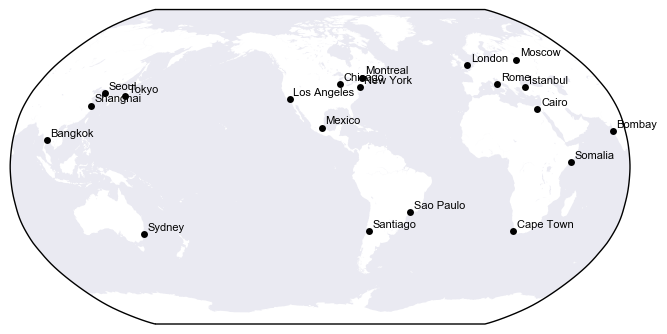

In [6]:
my_map = Basemap(projection='robin', lat_0=0, lon_0=-100,
                 resolution='l', area_thresh=1000.0)

#my_map.drawcoastlines()
#my_map.drawcountries()
my_map.fillcontinents(color = 'white')
#my_map.drawmapboundary()

#my_map.drawmeridians(np.arange(0, 360, 30))
#my_map.drawparallels(np.arange(-90, 90, 30))

lons = locs['Long'].as_matrix()
lats = locs['Lat'].as_matrix()
x,y = my_map(lons, lats)
my_map.plot(x, y, 'ko', markersize=5)
labels = locs['City'].as_matrix()
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt+200000, ypt+200000, label.replace("_", " "), size=8, color = 'black')
plt.show()

## Static 3D image: plot the high-dimensional data in a low dimensional space

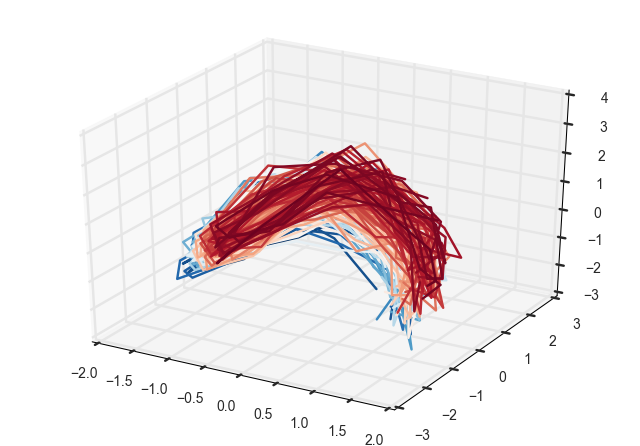

In [7]:
hyp.plot(temps, group=years.flatten(), palette='RdBu_r', labels=list(years.flatten()), explore = True)

## Static 2D image

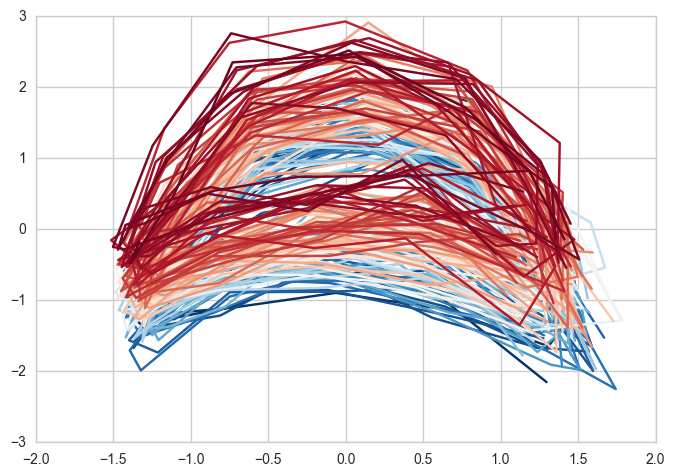

In [8]:
hyp.plot(temps, group=years.flatten(), palette='RdBu_r', ndims=2)

## Color Bar

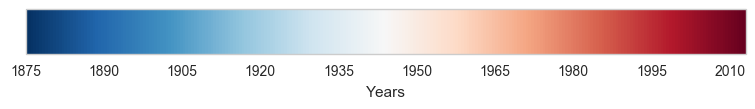

In [9]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=1875, vmax=2013)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Years')
plt.show()

## Lowess predictions of PCA values by year

In [10]:
sns.set_style('darkgrid')
sns.set_palette(palette='muted')
reduced_data = hyp.tools.reduce(temps, ndims = 3, normalize = False)

results['PCA 1'] = reduced_data[0][:,0]
results['PCA 2'] = reduced_data[0][:,1]
results['PCA 3'] = reduced_data[0][:,2]

PCA1_df = results[['Year', 'PCA 1']]
PCA2_df = results[['Year', 'PCA 2']]
PCA3_df = results[['Year', 'PCA 3']]

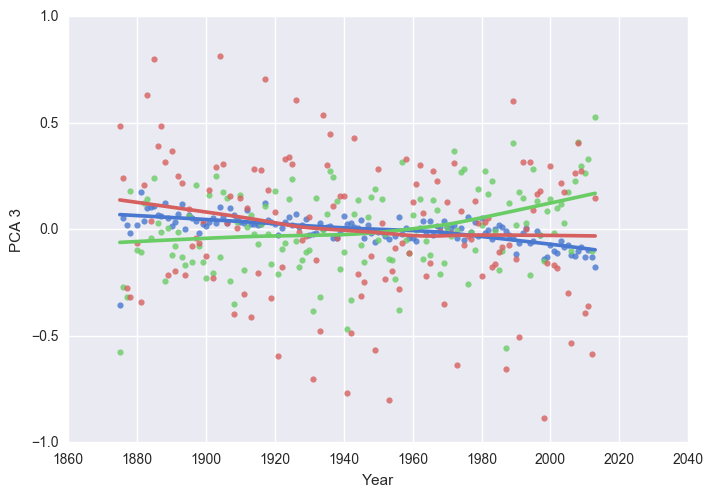

In [12]:
sns.regplot(x='Year', y='PCA 1', data=PCA1_df.groupby(['Year']).mean().reset_index(), lowess=True)
sns.regplot(x='Year', y='PCA 2', data=PCA2_df.groupby(['Year']).mean().reset_index(), lowess=True)
sns.regplot(x='Year', y='PCA 3', data=PCA3_df.groupby(['Year']).mean().reset_index(), lowess=True)
plt.show()

## Lowess predictions of PCA values by  average yearly temperature

In [13]:
temp_PCA = pd.DataFrame()
temp_PCA['ave_temp'] = results.groupby(['Year']).mean()[locs['City']].mean(axis=1)

In [14]:
temp_PCA = temp_PCA.join(PCA1_df.groupby(['Year']).mean(), how = 'outer')
temp_PCA = temp_PCA.join(PCA2_df.groupby(['Year']).mean(), how = 'outer')
temp_PCA = temp_PCA.join(PCA3_df.groupby(['Year']).mean(), how = 'outer')

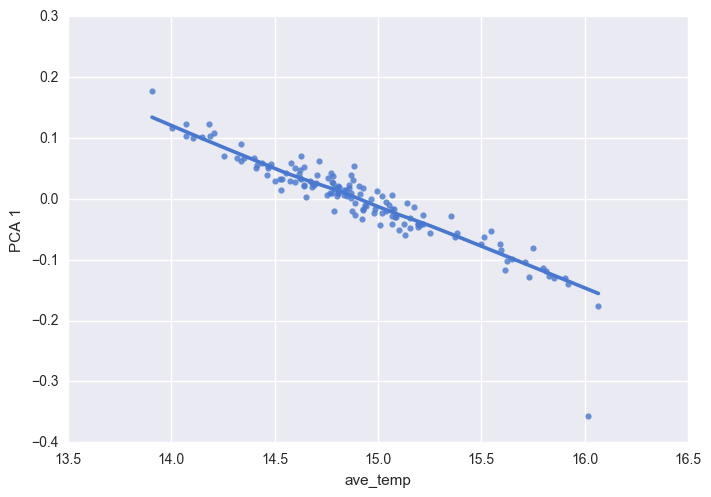

In [18]:
sns.regplot(x='ave_temp', y='PCA 1', data = temp_PCA, lowess=True)
plt.show()

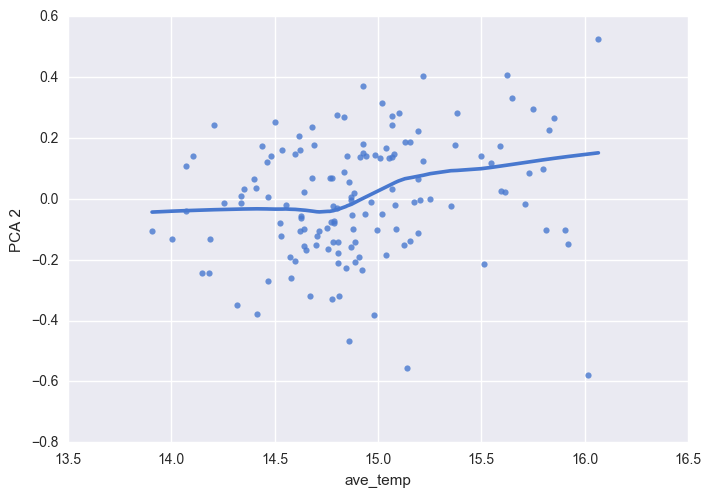

In [19]:
sns.regplot(x='ave_temp', y='PCA 2', data = temp_PCA, lowess=True)
plt.show()

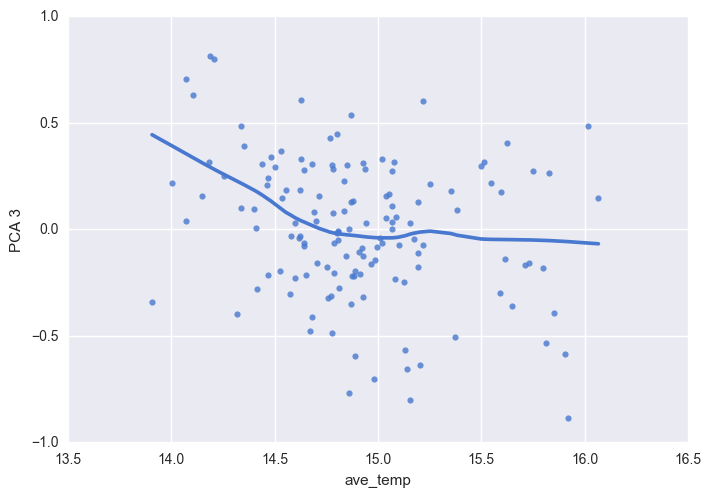

In [20]:
sns.regplot(x='ave_temp', y='PCA 3', data = temp_PCA, lowess=True)
plt.show()

## Linear regression predictions of PCA values by month

In [21]:
PCA1_df = results[['Month', 'Year', 'PCA 1']]
PCA2_df = results[['Month', 'Year', 'PCA 2']]
PCA3_df = results[['Month', 'Year', 'PCA 3']]

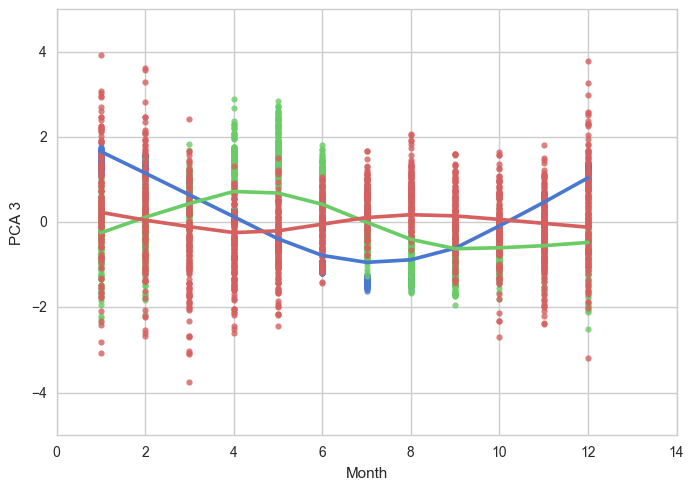

In [32]:
sns.regplot(x='Month', y='PCA 1', data=PCA1_df.groupby(['Month', 'Year']).mean().reset_index(), truncate = True, lowess=True)
sns.regplot(x='Month', y='PCA 2', data=PCA2_df.groupby(['Month', 'Year']).mean().reset_index(), truncate = True, lowess=True)
sns.regplot(x='Month', y='PCA 3', data=PCA3_df.groupby(['Month', 'Year']).mean().reset_index(), truncate = True, lowess=True)
plt.show()

In [25]:
temps_locs = pd.DataFrame()
temps_locs = results.groupby(['Year']).mean()[locs['City']].reset_index()

In [29]:
meltCov = pd.melt(temps_locs,id_vars=['Year'], var_name='Cities', value_name='Average Temperature')
sns.set(style="whitegrid")
sns.set_palette(palette='muted')
g = sns.lmplot(x = 'Year', y = 'Average Temperature', hue="Cities", data = meltCov, fit_reg=False, legend_out=True)
regplot = sns.regplot(x = 'Year', y = 'Average Temperature', data = meltCov, lowess = True, scatter=False, ax=g.axes[0, 0], color='k')
regplot.set(ylim=(0, 30), xlim=(1870,2040))

[(0, 30), (1870, 2040)]

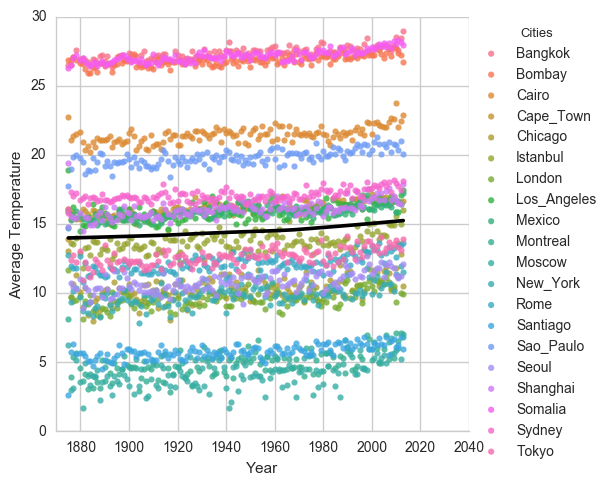

In [30]:
plt.show()